### Last updated: Sept 17, 2017

### Based on NeuroDataResource.py (by [bdstat](https://github.com/bstadt)) which can be found [here](https://github.com/NeuroDataDesign/nomads-f17s18/blob/master/source/bstadt/NeuroDataResource/NeuroDataResource.py).

In [1]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from NeuroDataResource import NeuroDataResource

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from matplotlib import pyplot as plt  # for displaying the image slices
import nibabel as nib  # for saving and loading the downloaded volume to nifti (.nii) files
import SimpleITK as sitk
from tifffile import imsave

# Connecting to the Boss Api

#### Api keys can be obtained from [here](https://api.boss.neurodata.io/v1/mgmt/token).

In [3]:
apiKey = pickle.load(open('.keys/boss_token.pkl', 'rb'))

# alternatively you could do:
# apiKey = <string of api key>

# but if you don't want to publicly display the key in the jupyter notebook, 
# you should just load the string of the key from a file like a .pkl

In [23]:
myResource = NeuroDataResource('api.boss.neurodata.io',
                               apiKey,
                               'ailey-dev',
                               '170726_Insula-vCapture-Atenolol2_00-56-01',
                               [{'name': 'Ch0', 'dtype':'uint16'}])

# Getting the cutout volume

In [24]:
x_range = [1560, 2160]
y_range = [677, 1177]
z_range = [622, 1022]

In [26]:
cutout = myResource.get_cutout('Ch0', z_range, y_range, x_range)
print('(z, y, x):')
print(cutout.shape)

(z, y, x):
(400, 500, 600)


In [27]:
print(type(cutout))

<type 'numpy.ndarray'>


# Displaying a slice of the cutout volume
### (somewhat hacky, i.e. not sure this is the best way)

In [9]:
# Getting a slice of the volume at z = 50 of the volume.
cutout_slice = cutout[50,:,:]

print(cutout_slice.shape)
print(cutout_slice)

(500, 600)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


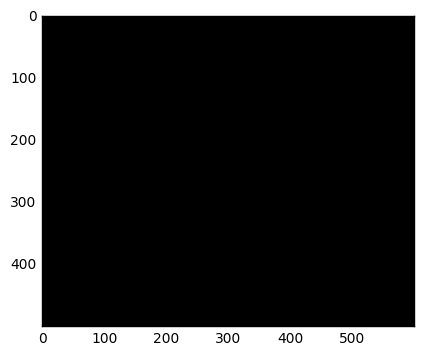

In [10]:
plt.imshow(cutout_slice, cmap='gray')
plt.show()

# Separating the cutout into 4 cutouts

In [28]:
# Separating cutouts
cutout_1 = cutout[0:100,:,:]
cutout_2 = cutout[100:200,:,:]
cutout_3 = cutout[200:300,:,:]
cutout_4 = cutout[300:400,:,:]

print(cutout_1.shape)
print(cutout_2.shape)
print(cutout_3.shape)
print(cutout_4.shape)

(100, 500, 600)
(100, 500, 600)
(100, 500, 600)
(100, 500, 600)


In [29]:
print(type(cutout_1[0,0,0]))

<type 'numpy.float64'>


# Saving to and loading from a TIFF stack

In [30]:
image_1 = sitk.GetImageFromArray(cutout_1)
image_2 = sitk.GetImageFromArray(cutout_2)
image_3 = sitk.GetImageFromArray(cutout_3)
image_4 = sitk.GetImageFromArray(cutout_4)

In [31]:
print(image_1.GetSize())
print(cutout_1.shape)
print(type(cutout_1[0,0,0]))

(600, 500, 100)
(100, 500, 600)
<type 'numpy.float64'>


In [32]:
# saving the cutout to a .tif, casting to uint16 first (the dtype it's downloaded as is uint16)
sitk.WriteImage(sitk.Cast(image_1, sitk.sitkUInt16), 'cell_detection_1.tif')
sitk.WriteImage(sitk.Cast(image_2, sitk.sitkUInt16), 'cell_detection_2.tif')
sitk.WriteImage(sitk.Cast(image_3, sitk.sitkUInt16), 'cell_detection_3.tif')
sitk.WriteImage(sitk.Cast(image_4, sitk.sitkUInt16), 'cell_detection_4.tif')

In [12]:
image_2_loaded = sitk.ReadImage('cell_detection_2.tif') #read image

In [13]:
loaded_tiff_cutout = sitk.GetArrayFromImage(image_2)
print(type(loaded_tiff_cutout))
print(loaded_tiff_cutout.shape)

<type 'numpy.ndarray'>
(100, 1000, 1000)


In [14]:
# Checking if the loaded image array and the downloaded on are the same
print(np.array_equal(cutout, loaded_tiff_cutout))

True


In [16]:
loaded_tiff_slice = loaded_tiff_cutout[50,:,:]

print(loaded_tiff_slice.shape)
print(loaded_tiff_slice)

(1000, 1000)
[[545 550 544 ..., 741 784 741]
 [559 564 588 ..., 748 763 782]
 [542 519 570 ..., 758 772 759]
 ..., 
 [819 777 804 ..., 766 830 775]
 [834 855 764 ..., 828 862 795]
 [769 744 797 ..., 882 827 835]]


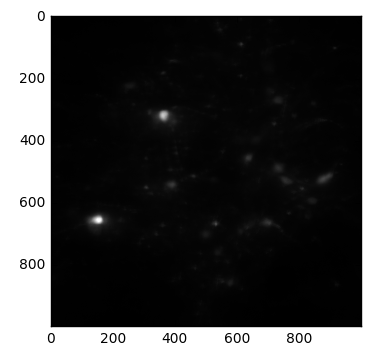

In [17]:
plt.imshow(loaded_tiff_slice, cmap='gray')
plt.show()

# Saving and loading using tiffile

In [10]:
imsave('s3617_tifffile'+'.tif', cutout)

In [8]:
# Using code from jyim6
max_grey_val = cutout.max(axis=1).max(axis=1).max()
dim = cutout.shape
cutout_rgb = np.zeros((dim[0], dim[1], dim[2], 3))
for i in range(dim[0]):
    for j in range(dim[1]):
        for k in range(dim[2]):
            normalized_rgb = int( 255 * (cutout[i][j][k]/max_grey_val) )
            for p in range(3):
                cutout_rgb[i][j][k][p] = normalized_rgb
imsave('s3617_tifffile'+'.tif', cutout_rgb.astype(np.uint16))

KeyboardInterrupt: 

# Saving to and loading from a nifti (.nii) file

In [48]:
# nib.Nifti1Image can take 3 arguments, of which only the first two are manditory.
# nib.Nifti1Image(image_data, img_affine, img_header)
# TODO: I didn't add header data when saving because I don't know how to obtain that at this moment, 
# not sure if necessary though.
nifti_img = nib.Nifti1Image(cutout, np.eye(4))

In [50]:
nib.save(nifti_img, 's3617_cutout.nii')

In [56]:
loaded_img = nib.load('s3617_cutout.nii')
print(type(loaded_img))

# Get a plain numpy array, without all the metadata 
loaded_cutout = loaded_img.get_data()
print(type(loaded_cutout))
print('(z, y, x)')
print(loaded_cutout.shape)

<class 'nibabel.nifti1.Nifti1Image'>
<class 'numpy.core.memmap.memmap'>
(z, y, x)
(100, 1000, 1000)


## Verify that the saved and loaded cutout is the same as the downloaded cutout

#### This just consists of seeing if the numpy arrays are equal and visually comparing slices between the downloaded cutout and the loaded cutout and seeing if they look the same.

In [62]:
print(np.array_equal(cutout, loaded_cutout))

True


In [57]:
loaded_cutout_slice = loaded_cutout[50,:,:]

print(cutout_slice.shape)
print(cutout_slice)

(1000, 1000)
[[ 545.  550.  544. ...,  741.  784.  741.]
 [ 559.  564.  588. ...,  748.  763.  782.]
 [ 542.  519.  570. ...,  758.  772.  759.]
 ..., 
 [ 819.  777.  804. ...,  766.  830.  775.]
 [ 834.  855.  764. ...,  828.  862.  795.]
 [ 769.  744.  797. ...,  882.  827.  835.]]


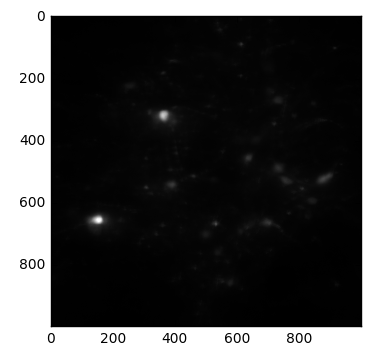

In [58]:
plt.imshow(cutout_slice, cmap='gray')
plt.show()